In [30]:
import pandas as pd
df = pd.read_csv('csv/decessi_tot.csv')
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [31]:
#df.set_index('Data', inplace=True)
#df=df.drop('2016-02-29', axis=0)
#df=df.drop('2020-02-29', axis=0)
#df.head()

In [32]:
#df=df.reset_index()
#df.head()

In [33]:
#trasformo le date e i numeri
df.Data = pd.to_datetime(df.Data, dayfirst=True)
df.Totale = pd.to_numeric(df.Totale)
df.head()

,Data,Totale
0,2015-01-01,151
1,2015-01-02,160
2,2015-01-03,145
3,2015-01-04,153
4,2015-01-05,171


In [34]:
df=df.set_index('Data')
df.head()

,Totale
Data,
2015-01-01,151
2015-01-02,160
2015-01-03,145
2015-01-04,153
2015-01-05,171


In [35]:
#creo la time series
ts = df.Totale
ts.head()

Data
2015-01-01    151
2015-01-02    160
2015-01-03    145
2015-01-04    153
2015-01-05    171
Name: Totale, dtype: int64

In [36]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,4,30)
lim_ts = ts[start_date:end_date]

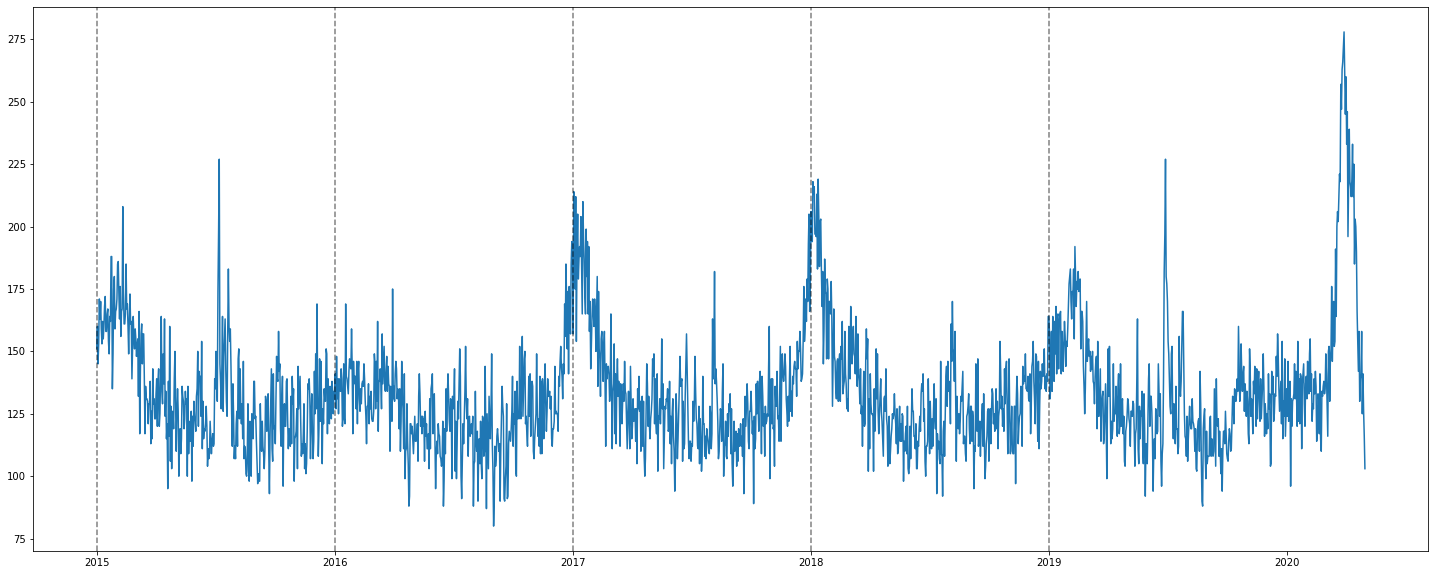

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

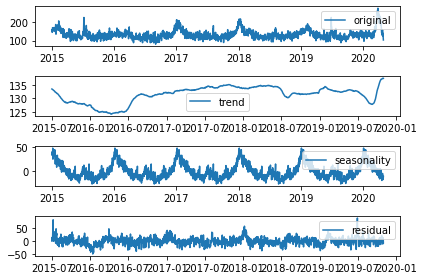

In [38]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365)

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

In [39]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")

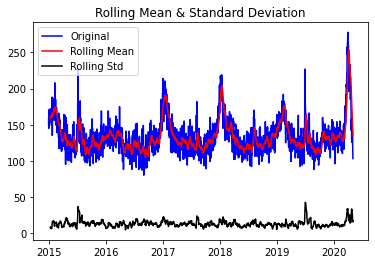

Results of Dickey-Fuller Test:
Test Statistic                   -5.023434
p-value                           0.000020
#Lags Used                        8.000000
Number of Observations Used    1938.000000
Critical Value (1%)              -3.433729
Critical Value (5%)              -2.863033
Critical Value (10%)             -2.567565
dtype: float64
X is stationary


In [40]:
test_stationarity(lim_ts)

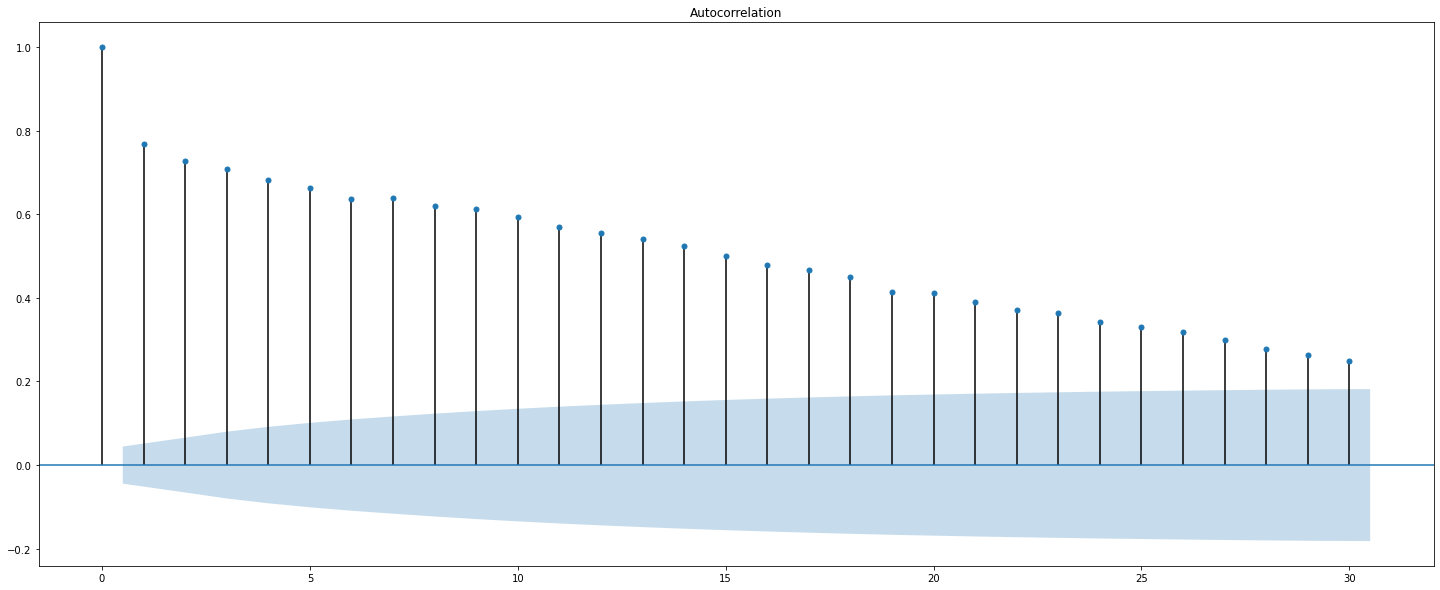

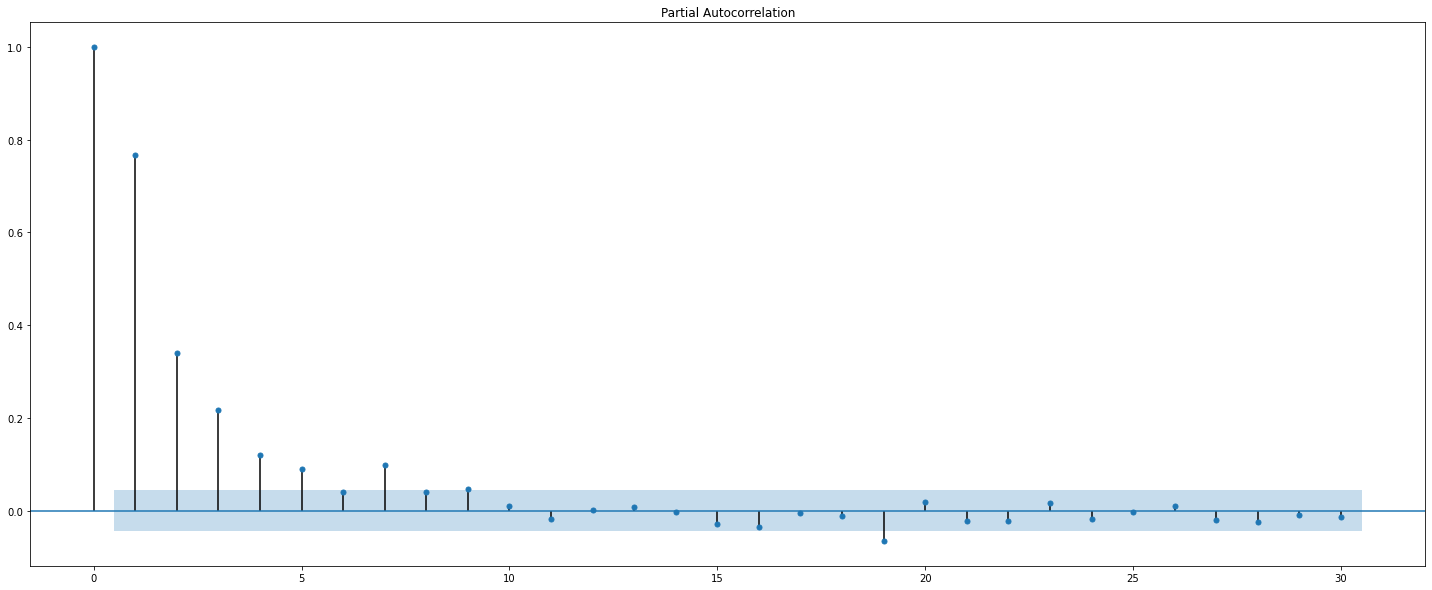

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig_acf,ax_acf = plt.subplots(figsize=(25, 10))
fig_pacf,ax_pacf = plt.subplots(figsize=(25, 10))
plot_acf(ts, lags =30, ax=ax_acf)
plot_pacf(ts, lags =30, ax=ax_pacf)
plt.show()

In [42]:
from datetime import datetime
train_end = datetime(2019,12,31)
test_end = datetime (2020,4,30)

train = ts[:train_end]
test = ts[train_end + timedelta(days=1): test_end]


In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p = 4
q = 2
d = 0

#S = 365

model = SARIMAX(train, order=(p, d, q), 
                #seasonal_order=(0, 1, 0, S)
               )
model_fit = model.fit(disp=1,solver='powell')
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                               SARIMAX Results                                
Dep. Variable:                 Totale   No. Observations:                 1826
Model:               SARIMAX(4, 0, 2)   Log Likelihood               -7390.961
Date:                Thu, 16 Jul 2020   AIC                          14795.923
Time:                        16:40:09   BIC                          14834.492
Sample:                    01-01-2015   HQIC                         14810.150
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2142      0.028      7.537      0.000       0.158       0.270
ar.L2          1.0304      0.028     37.192      0.000       0.976       1.085
ar.L3         -0.1851      0.028     -6.672      0.0

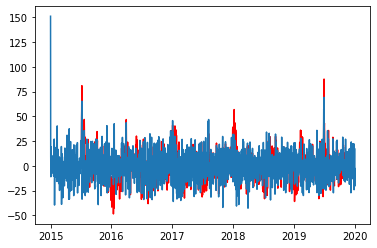

In [61]:
residuals = model_fit.resid
plt.plot(ts_residual, color='red')
plt.plot(residuals)

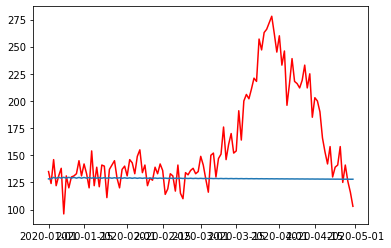

In [62]:
# predizioni sul test set
predictions = model_fit.forecast(steps=len(test)) 
plt.plot(test, color='red')
plt.plot(predictions)

In [55]:
test

Data
2020-01-01    135
2020-01-02    124
2020-01-03    146
2020-01-04    122
2020-01-05    131
             ... 
2020-04-26    125
2020-04-27    141
2020-04-28    126
2020-04-29    116
2020-04-30    103
Name: Totale, Length: 121, dtype: int64